STEP 1: Load the dataset

In [2]:
import kagglehub
import os

path = kagglehub.dataset_download("yasserh/titanic-dataset")
print("Downloaded path:", path)

print("\nFiles inside the folder:")
print(os.listdir(path))


Using Colab cache for faster access to the 'titanic-dataset' dataset.
Downloaded path: /kaggle/input/titanic-dataset

Files inside the folder:
['Titanic-Dataset.csv']


In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv("/kaggle/input/titanic-dataset/Titanic-Dataset.csv")

print("Shape:", df.shape)

print("\n--- HEAD ---")
print(df.head())

print("\n--- INFO ---")
print(df.info())

print("\n--- DESCRIBE ---")
print(df.describe(include='all').T)

print("\n--- MISSING VALUES ---")
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (df.isnull().mean() * 100).sort_values(ascending=False)
missing_df = pd.concat([missing, missing_pct], axis=1)
missing_df.columns = ["missing_count", "missing_percent"]
print(missing_df[missing_df["missing_count"] > 0])

print("\n--- DUPLICATES ---")
print("Duplicate rows:", df.duplicated().sum())


Shape: (891, 12)

--- HEAD ---
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            3734


STEP 2: DATA CLEANING

In [6]:

import pandas as pd
import numpy as np
df = pd.read_csv("/kaggle/input/titanic-dataset/Titanic-Dataset.csv")

# 1. HANDLE MISSING VALUES
# Extract Deck from Cabin
df['Deck'] = df['Cabin'].astype(str).str[0]     # Extract first letter
df['Deck'] = df['Deck'].replace('n', 'U')       # 'nan' becomes 'U'
df['Deck'] = df['Deck'].fillna('U')

# Drop the original Cabin column
df = df.drop(columns=['Cabin'])

# Age → median imputation
df['Age'] = df['Age'].fillna(df['Age'].median())

# Embarked → mode imputation
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])


# 2. FIX DATA TYPES

df['Pclass'] = df['Pclass'].astype('category')
df['Sex'] = df['Sex'].astype('category')
df['Embarked'] = df['Embarked'].astype('category')
df['Deck'] = df['Deck'].astype('category')


# 3. REMOVE DUPLICATES

df = df.drop_duplicates()


# 4. OUTLIER HANDLING (IQR METHOD)

def clip_outliers(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return col.clip(lower, upper)

df['Age'] = clip_outliers(df['Age'])
df['Fare'] = clip_outliers(df['Fare'])


# CHECK RESULTS
print("Missing values after cleaning:")
print(df.isnull().sum())

print("\nData types after cleaning:")
print(df.dtypes)

print("\nSample after cleaning:")
print(df.head())


Missing values after cleaning:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Deck           0
dtype: int64

Data types after cleaning:
PassengerId       int64
Survived          int64
Pclass         category
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Embarked       category
Deck           category
dtype: object

Sample after cleaning:
   PassengerId  Survived Pclass  \
0            1         0      3   
1            2         1      1   
2            3         1      3   
3            4         1      1   
4            5         0      3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Fl

STEP 3: EDA (Exploratory Data Analysis)

In [10]:
#Setup
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.autolayout'] = True


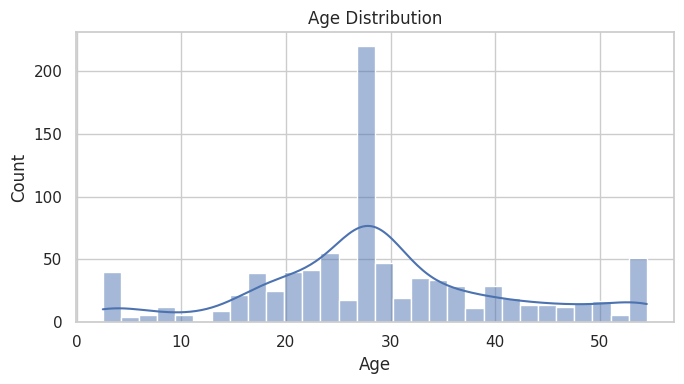

In [11]:
#Age Distribution
plt.figure(figsize=(7,4))
sns.histplot(df['Age'], bins=30, kde=True)
plt.title("Age Distribution")
plt.show()


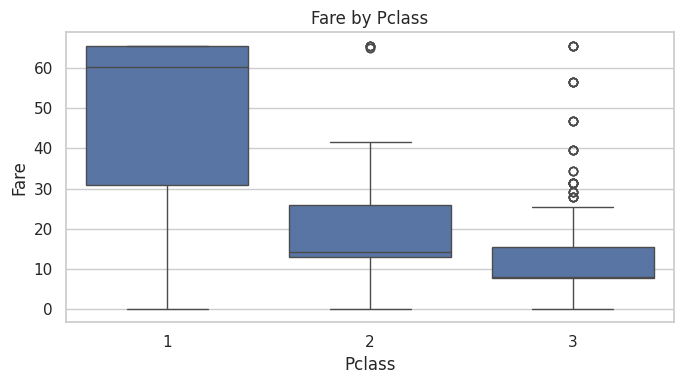

In [12]:
#Fare by Pclass (Boxplot)
plt.figure(figsize=(7,4))
sns.boxplot(x='Pclass', y='Fare', data=df)
plt.title("Fare by Pclass")
plt.show()

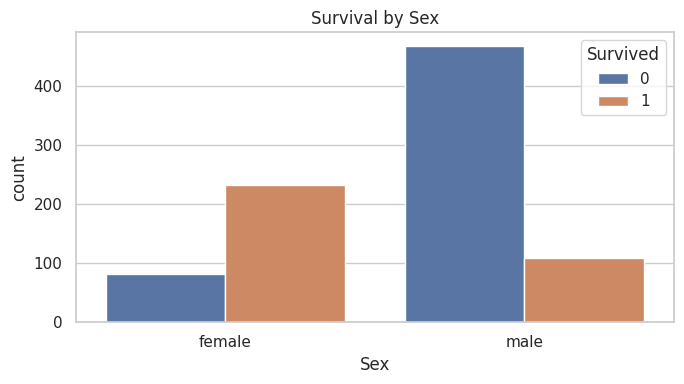

In [13]:
#Survival by Sex
plt.figure(figsize=(7,4))
sns.countplot(x='Sex', hue='Survived', data=df)
plt.title("Survival by Sex")
plt.show()

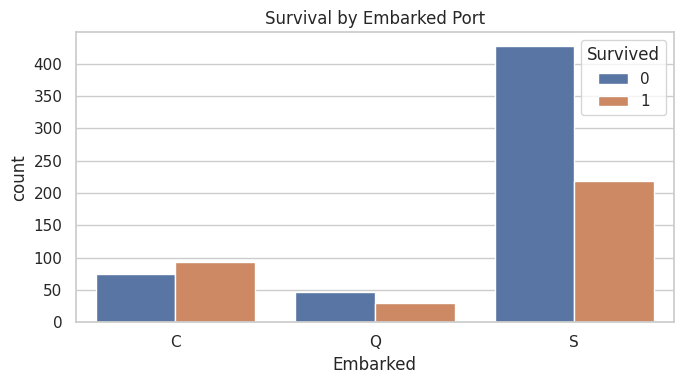

In [14]:
#Survival by Embarked Port
plt.figure(figsize=(7,4))
sns.countplot(x='Embarked', hue='Survived', data=df)
plt.title("Survival by Embarked Port")
plt.show()

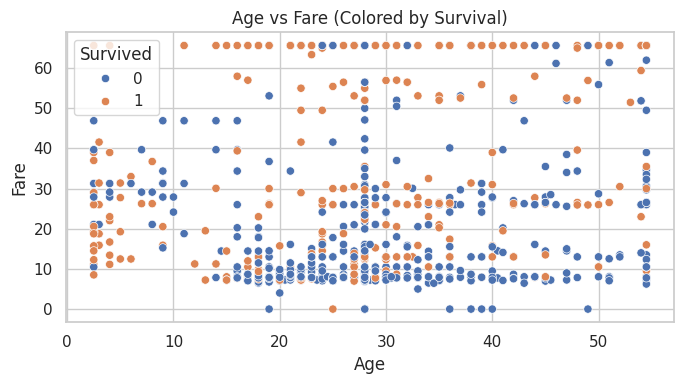

In [15]:
#Age vs Fare Scatter
plt.figure(figsize=(7,4))
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=df)
plt.title("Age vs Fare (Colored by Survival)")
plt.show()


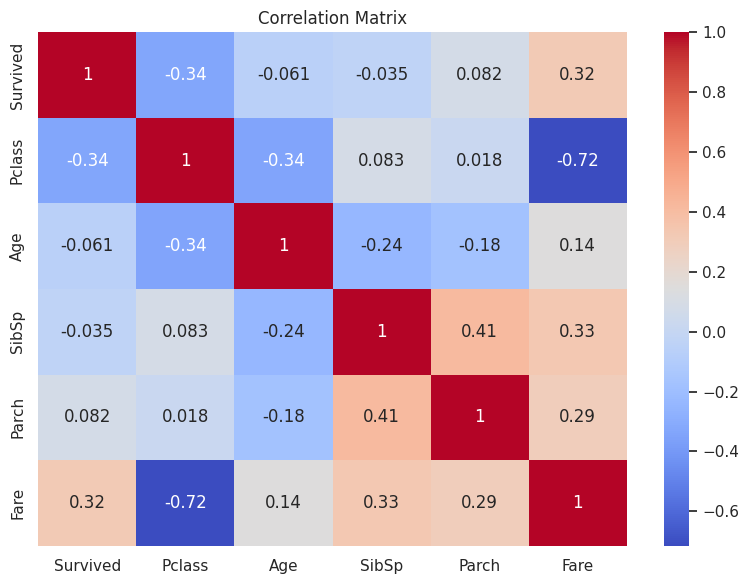

In [16]:
#Correlation Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[['Survived','Pclass','Age','SibSp','Parch','Fare']].corr(),
            annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


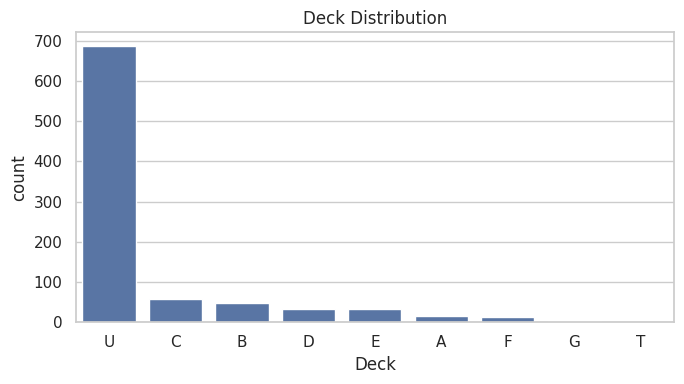

In [17]:
#Deck Distribution
plt.figure(figsize=(7,4))
sns.countplot(x='Deck', data=df, order=df['Deck'].value_counts().index)
plt.title("Deck Distribution")
plt.show()


STEP 4: FEATURE ENGINEERING

In [18]:

from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import re

# Make a copy
df_fe = df.copy()

# 1️. Label Encoding: Sex
le_sex = LabelEncoder()
df_fe['Sex_enc'] = le_sex.fit_transform(df_fe['Sex'])

# 2️. Creating new features

# Family Size
df_fe['FamilySize'] = df_fe['SibSp'] + df_fe['Parch'] + 1

# IsAlone
df_fe['IsAlone'] = (df_fe['FamilySize'] == 1).astype(int)

# Title extraction
def extract_title(name):
    m = re.search(r',\s*([^.]*)\.', name)
    return m.group(1).strip() if m else 'Unknown'

df_fe['Title'] = df_fe['Name'].apply(extract_title)

# Replace rare titles
rare_titles = df_fe['Title'].value_counts()[df_fe['Title'].value_counts() < 10].index
df_fe['Title'] = df_fe['Title'].replace(rare_titles, 'Rare')

# Encode Title
le_title = LabelEncoder()
df_fe['Title_enc'] = le_title.fit_transform(df_fe['Title'])

# 3️. One-Hot Encoding for Embarked, Pclass, Deck
df_fe = pd.get_dummies(df_fe, columns=['Embarked', 'Pclass', 'Deck'], drop_first=True)

# 4️. Scaling Age and Fare
scaler = StandardScaler()
df_fe[['Age_s', 'Fare_s']] = scaler.fit_transform(df_fe[['Age', 'Fare']])

print("Feature engineering completed.")
print(df_fe.head())
print("\nNew columns added:", df_fe.columns[-15:])


Feature engineering completed.
   PassengerId  Survived                                               Name  \
0            1         0                            Braund, Mr. Owen Harris   
1            2         1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2            3         1                             Heikkinen, Miss. Laina   
3            4         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4            5         0                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch            Ticket     Fare  Sex_enc  ...  \
0    male  22.0      1      0         A/5 21171   7.2500        1  ...   
1  female  38.0      1      0          PC 17599  65.6344        0  ...   
2  female  26.0      0      0  STON/O2. 3101282   7.9250        0  ...   
3  female  35.0      1      0            113803  53.1000        0  ...   
4    male  35.0      0      0            373450   8.0500        1  ...   

   Deck_B  Deck_C Deck_D  Deck_E  Deck_F  Deck_G 

STEP 5: MODEL TRAINING

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# 1️. Select features (all numeric + engineered + one-hot)
feature_cols = [
    'Sex_enc', 'Age_s', 'Fare_s', 'FamilySize', 'IsAlone', 'Title_enc',
    'Embarked_Q', 'Embarked_S',
    'Pclass_2', 'Pclass_3',
    'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U'
]

X = df_fe[feature_cols]
y = df_fe['Survived']

# 2️. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3️. Train Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# 4️. Train Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# 5️. Evaluate models
def evaluate_model(model):
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]
    return {
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'F1': f1_score(y_test, preds),
        'ROC_AUC': roc_auc_score(y_test, proba)
    }

logreg_results = evaluate_model(logreg)
rf_results = evaluate_model(rf)

print("Logistic Regression Results:")
print(logreg_results)

print("\nRandom Forest Results:")
print(rf_results)


Logistic Regression Results:
{'Accuracy': 0.8156424581005587, 'Precision': 0.8, 'Recall': 0.6956521739130435, 'F1': 0.7441860465116279, 'ROC_AUC': np.float64(0.8364953886693017)}

Random Forest Results:
{'Accuracy': 0.7877094972067039, 'Precision': 0.7384615384615385, 'Recall': 0.6956521739130435, 'F1': 0.7164179104477612, 'ROC_AUC': np.float64(0.8318840579710145)}


Step 6: Model Evaluation Visuals

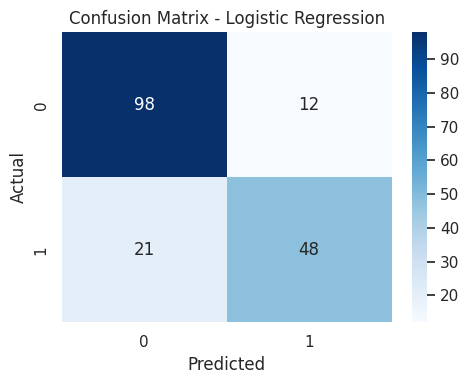

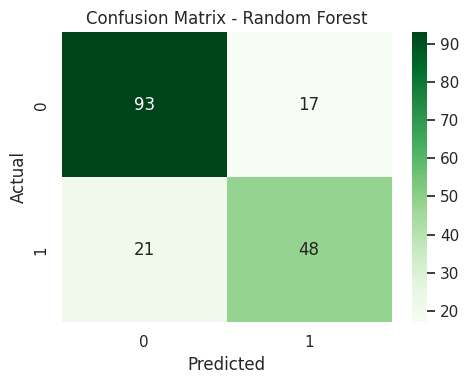

In [21]:
#Confusion Matrices

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Logistic Regression confusion matrix
pred_log = logreg.predict(X_test)
cm_log = confusion_matrix(y_test, pred_log)

plt.figure(figsize=(5,4))
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Random Forest confusion matrix
pred_rf = rf.predict(X_test)
cm_rf = confusion_matrix(y_test, pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


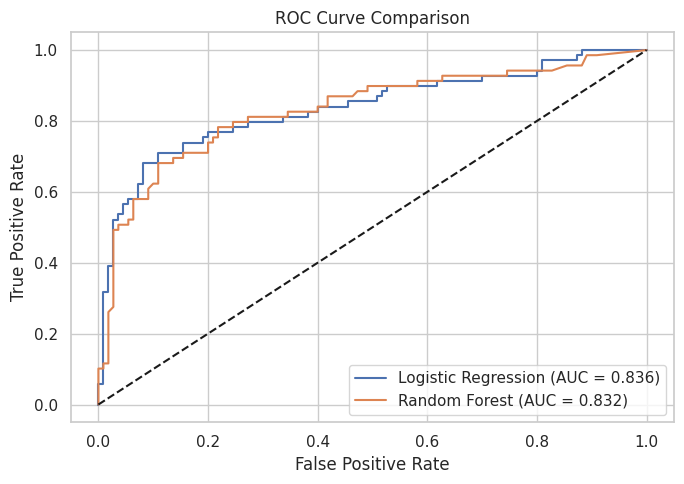

In [22]:
#ROC Curves
from sklearn.metrics import roc_curve, auc

# Probabilities
log_pred_proba = logreg.predict_proba(X_test)[:,1]
rf_pred_proba = rf.predict_proba(X_test)[:,1]

# ROC curves
fpr_log, tpr_log, _ = roc_curve(y_test, log_pred_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {logreg_results['ROC_AUC']:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_results['ROC_AUC']:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()
